# Introduction

### Problem statement
More than 1 million people are hospitalized with pneumonia each year, which is a very serious problem. Chest X-Rays are currently the best method available for diagnosing it. The task is to classify if a person has pneumonia or not. Further, the classification model has to be deployed onto a mobile device for real time inference.

The following link contains information about the popular existing applications in medical dimain: https://www.grantsformedical.com/apps-for-medical-diagnosis.html

The above was especially useful during the times when COVID-19 was known to cause pneumonia.

The image below shows a visual comparison of a normal lung (left) and a lung affected by pneumonia (right).

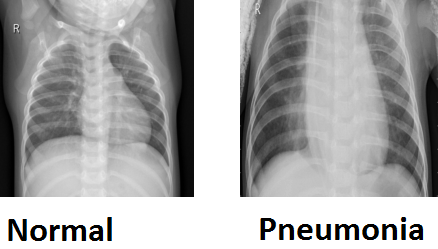

Observe that there is severe glass opacity in the image on the right  mainly due to air displacement by fluids.

### What is pneumonia?
Pneumonia is a lung infection that inflames the air sacs within the lungs. These air sacs, known as alveoli, can become filled with fluids or pus, hindering the efficient exchange of oxygen and carbon di-oxide. This can lead to a range of symptoms, including,
- Cough (often producing phlegm or pus).
- Fever or chills.
- Difficulty breathing.
- Chest pain.
- Fatigue.
- Confusion (particularly in older adults).

Various microorganisms, such as bacteria, viruses (like influenza or the virus that causes COVID-19) and fungi can cause pneumonia.

The severity of pneumonia can vary widely, from mild to life-threatening. Individuals at higher rist of severe illness include,
- Infants and young children.
- Adults aged 65 and older.
- People with weakened immune systems.
- Individuals with underlying health conditions such as chrinic lung diseases (asthma, CPOD), heart disease or diabetes.

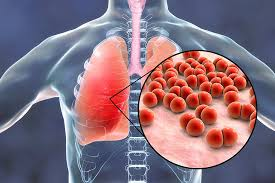

### Agenda and motivation
Computer Vision has a lot of applications in medical diagnosis. This document walks through the compelte pipeline from loading the data to predicting results. It also explains how to build an X-Ray image classification model using CNN to predict whether an X-Ray scan shows the presence of pneumonia.

### Real-time constraints
- Low latency requirements.
- False positive (type 1 error) or false negative (type 2 error) can be expensive.
- The model should ne confident in predicting the correct class.
- The model should be explainable through visualizations.

# How Will The Problem Be Solved?
Model like VGG-16, VGG-19, ResNets, etc, are state-of-the-art, but they are computationally expensive and cannot be deployed on mobile devices, where processing power and battery life are limited.

### Enter MobileNet
- MobileNet is a lightweight and efficient CNN architecture specifically designed for mobile and embedded devices.
- Key advantages:
    - High accuracy: Achieves competitive accuracy compared to larger models.
    - Small size: Significantly smaller model size (100x smaller in this case) translates to lower memory requirements and faster loading times.
    - Low latency: Enables real-time inference on mobile devices, crucial for applications like object detection in real-time.
- In summary, MobileNet is a suitable choice for this scenario due to its combination of high accuracy, small size and low latency. This makes it well suited for deployment on mobile devices, where computational resources are limited and real-time performance is essential.

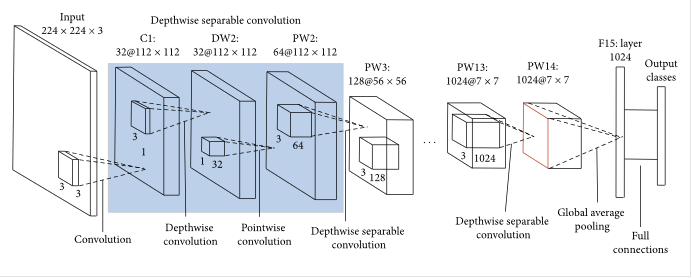

### TPUs
Apart from the above, TPUs will also be used.

TPUs (Tensor Processing Units) are Google's custom-designed application-specific integrated circuits (ASICs) specifically optimized for accelerating optimized for accelerating Machine Learning workloads. The following is a breakdown,
- Core function: TPUs excel at performing tensor operations, which are the fundamental building blocks of many Deep Learning algorithms.
- Key features:
    - High performance: Offer exceptional computational power, capable of delivering upto 180 teraflops of floating-point performance per chip.
    - High bandwidth memory: Equipped with 64 GB of high-bandwidth memory, enabling efficient data transfer and reducing bottlenecks.
    - Specialized architecture: Designed with a focus on matrix multiplication and other operations commonly found in Neural Networks.
- Availability:
    - Initially primarily available on Google Cloud, TPUs are now accessible through Google Colab, providing researchers and developers with a convenient way to leverage their power.

The following are the benefits of using TPUs,
- Significantly faster training times: TPUs can dramatically accelerate the training process for Deep Learning models, reducing the time required to develop and iterate on models.
- Improved scalability: TPUs can be easily scaled to handle large-scale training jobs, allowing for faster experimentation and model deployment.
- Reduced training costs: By accelerating training, TPUs can help reduce the overall cost of training Deep Learning models.

In [1]:
# importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

In [2]:
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")

`tf.distribute.Strategy` is a TensorFlow API to distribute training across multiple GPUs, multiple machines or TPUs. Using this API, the existing models and training code can be distributed with minimal code changes.

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print(f"Device: {tpu.master()}")
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print(f"Number of replicas = {strategy.num_replicas_in_sync}")

Number of replicas = 1


In [4]:
# the key configiration parameters that will be used are defined below
# in order to tun on TPU, this should be run on Google Colab with TPU runtime selected

AUTOTUNE = tf.data.AUTOTUNE

# specifying the training batch size
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# specifying the image size
IMAGE_SIZE = [224, 224]

# list containing class names, which will be used to index on the model output
# 0 = NORMAL, 1 = PNEUMONIA
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

`tf.data.AUTOTUNE` is a configuration option in the TensorFlow library that allows the `tf.data` API to automatically tune the performance of the data pipeline. The following is a breakdown of how it works,
- Performance model building: When a parameter is set to `AUTOTUNE`, the `tf.data` API starts building a performance model of the input pipeline. This model monitors how long each operation in the pipeline takes to execute.
- Optimization algorithm: Based on the performance model, `tf.data` employs an optimization algorithm to determine the optimal allocation of CPU resources across all operations specified as `AUTOTUNE`. This essentially involves finding the best balance between different operations to ensure efficient data processing.
- Continuous monitoring: While the data pipeline is running, `tf.data` keeps track of the time spent on each operation. This ongoing monitoring allows the optimization algorithm to adapt and refine resource allocation over time.

Benefits of using `tf.data.AUTOTUNE` are,
- Reduced manula tuning: By automating the optimization process, `tf.data.AUTOTUNE` eliminates the need for manual trial-and-error to find the best configuration for the data pipeline. This can save a significant time and effort.
- Improved performance: The optimization algorithm often leads to a more efficient data pipeline, resulting in faster data processing and potentially reduced training times for the ML models.
- Adaptability: `tf.data.AUTOTUNE` continuously monitors and adjusts resoruce allocation, enabling the data pipeline to adapt to changing hardware conditions or workload patterns.

# Dataset
The dataset is present in the TFRecord file format. TFRecord is a TensorFlow's proprietory binary storage format. It stores data as a sequence of binary strings, making it efficient for handling large datasets.

### Key advantages
- Space efficiency: Binary data generally occupies less disk space compared to text-based formats.
- Faster I/O: Reading binary data from disk is significantly faster than reading text data, leading to improved data loading performance.
- Optimized for TensorFlow: TFRecord is specifically designed to work seamlessly with TensorFlow's data input pipelines, enabling efficient data loading and processing.

### Benefits for large datasets
- Reduced storage costs: Smaller file sizes translate to lower storage costs, especially for massive datasets.
- Faster training: Efficient data loading and processing with TFRecord can significantly speed up the training process, reducing the time required to train complex models.
- Improved scalability: TFRecord can be effectively used with distributed training systems, enabling efficient data distribution across multiple machines.

In [5]:
# import ssl

# ssl._create_default_https_context = ssl._create_unverified_context

train_images = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec")
train_paths = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec")

ds = tf.data.Dataset.zip((train_images, train_paths))

In [7]:
COUNT_NORMAL = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print(f"Normal images count in training dataset = {str(COUNT_NORMAL)}")

COUNT_PNEUMONIA = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print(f"Normal images count in training dataset = {str(COUNT_PNEUMONIA)}")

print(f"Total count of images = {COUNT_NORMAL + COUNT_PNEUMONIA}")

2025-01-08 19:21:57.295774: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-01-08 19:21:57.356401: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2025-01-08 19:22:00.017102: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Normal images count in training dataset = 1349
Normal images count in training dataset = 3883
Total count of images = 5232


2025-01-08 19:22:01.749435: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Observe that there are way more images that are classified as pneumonia then normal. This means that there is a class imbalance persent in the dataset, this by extension can result in the model being biased towards the majority class (pneumonia).

# Addressing The Problem Of Class Imbalance